In [16]:
import os
os.system("pip install factor_analyzer")

0

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
import matplotlib.pyplot as plt
import seaborn as sns


KMO Test: 0.630
KMO value is acceptable for factor analysis.
Bartlett's Test: chi-square = 10240.714, p-value = 0.00000
Bartlett's test is significant, data is suitable for factor analysis.


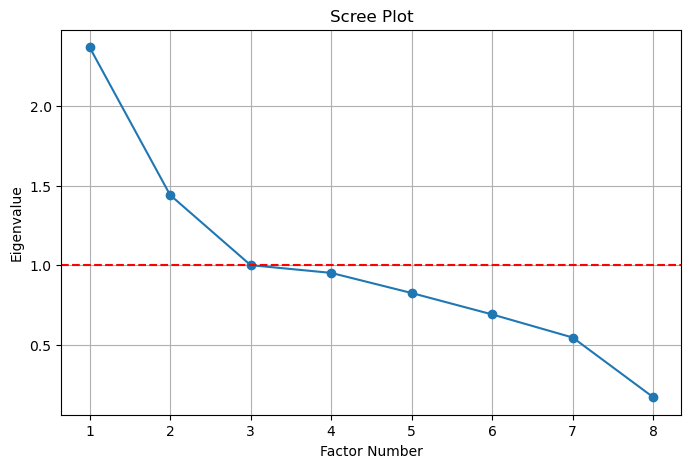

Factor Loadings:
                   Factor 1  Factor 2
pc11_vd_p_sch_gov  0.927703  0.089063
pc11_vd_m_sch_gov  0.886490  0.066702
pc11_vd_ph_cntr    0.018103  0.005397
pc11_vd_all_hosp   0.184664  0.025613
pc11_vd_phone      0.155727  0.711523
pc11_vd_mobl_cov   0.077105  0.578067
pc11_vd_bus_gov    0.083978  0.478654
pc11_vd_rs_fac     0.330142  0.202454
Correlation Matrix:
                  Factor 1  Factor 2  Total Population
Factor 1          1.000000  0.051997          0.746933
Factor 2          0.051997  1.000000          0.108392
Total Population  0.746933  0.108392          1.000000


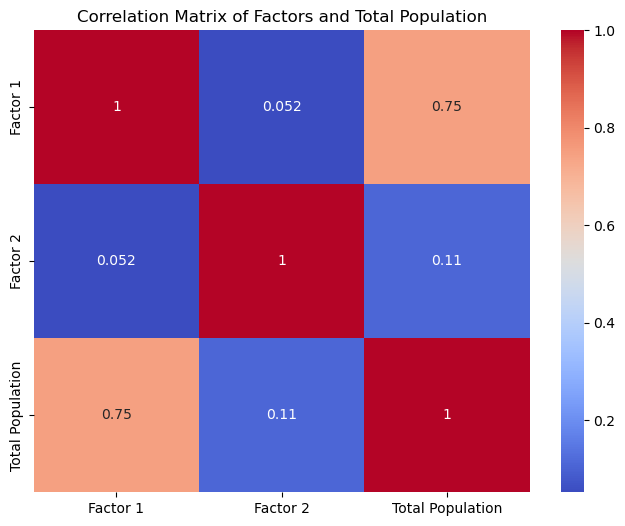

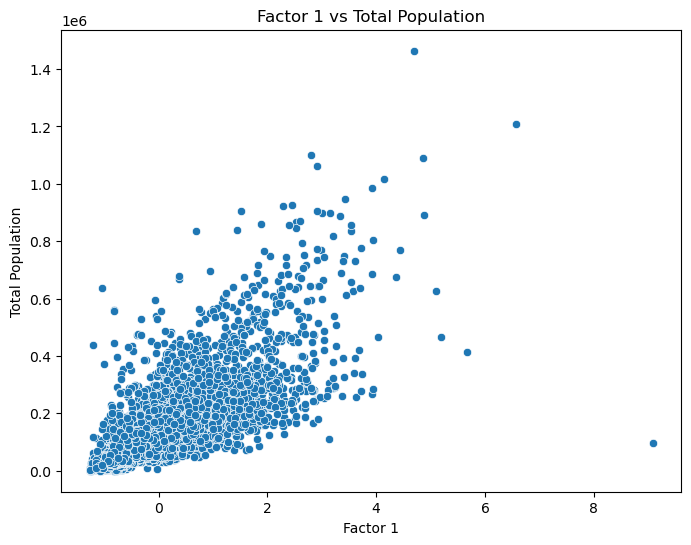

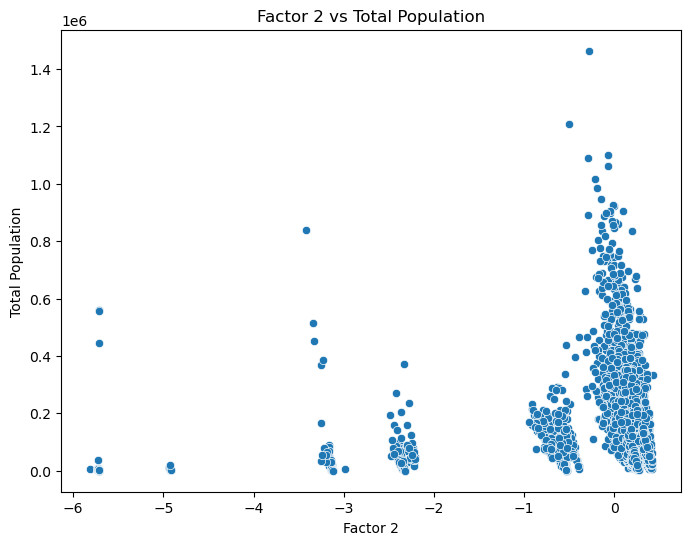

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Replace 'census_2011.csv' with the actual file path
data_2011 = pd.read_csv('pc11_vd_clean_pc11subdist.csv')

# Select relevant variables
variables = [
    'pc11_vd_p_sch_gov',   # Number of government primary schools
    'pc11_vd_m_sch_gov',   # Number of government middle schools
    'pc11_vd_ph_cntr',     # Number of primary health centres
    'pc11_vd_all_hosp',    # Number of allopathic hospitals
    'pc11_vd_phone',       # Number of telephones
    'pc11_vd_mobl_cov',    # Mobile phone coverage (binary)
    'pc11_vd_bus_gov',     # Public bus service (binary)
    'pc11_vd_rs_fac',      # Railway station (binary)
    'pc11_vd_t_p'          # Total population
]

# Prepare the data
data = data_2011[variables].dropna()

# Convert binary variables to integers
binary_vars = ['pc11_vd_mobl_cov', 'pc11_vd_bus_gov', 'pc11_vd_rs_fac']
data[binary_vars] = data[binary_vars].astype(int)

# Separate the population variable for later correlation analysis
population = data['pc11_vd_t_p']
data_features = data.drop(columns=['pc11_vd_t_p'])

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

# Assess suitability for factor analysis
kmo_all, kmo_model = calculate_kmo(data_scaled)
print(f"KMO Test: {kmo_model:.3f}")
if kmo_model < 0.6:
    print("KMO value is less than 0.6, data may not be suitable for factor analysis.")
else:
    print("KMO value is acceptable for factor analysis.")

chi_square_value, p_value = calculate_bartlett_sphericity(data_scaled)
print(f"Bartlett's Test: chi-square = {chi_square_value:.3f}, p-value = {p_value:.5f}")
if p_value < 0.05:
    print("Bartlett's test is significant, data is suitable for factor analysis.")
else:
    print("Bartlett's test is not significant, data may not be suitable.")

# Determine the number of factors
fa = FactorAnalyzer()
fa.fit(data_scaled)
eigenvalues, vectors = fa.get_eigenvalues()

# Plot the scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

# Based on the scree plot, choose the number of factors (e.g., 2 factors)
n_factors = 2

# Perform factor analysis with varimax rotation
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(data_scaled)

# Get factor loadings
loadings = fa.loadings_
factor_names = [f'Factor {i+1}' for i in range(n_factors)]
loadings_df = pd.DataFrame(loadings, index=data_features.columns, columns=factor_names)
print("Factor Loadings:")
print(loadings_df)

# Interpret the factors
# Factor Scores
factor_scores = fa.transform(data_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=factor_names)

# Add population back for correlation
factor_scores_df['Total Population'] = population.reset_index(drop=True)

# Correlation analysis
corr = factor_scores_df.corr()
print("Correlation Matrix:")
print(corr)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Factors and Total Population')
plt.show()

# Scatter plot between factors and population
for factor in factor_names:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=factor_scores_df, x=factor, y='Total Population')
    plt.title(f'{factor} vs Total Population')
    plt.xlabel(factor)
    plt.ylabel('Total Population')
    plt.show()
